In [2]:
import scanpy as sc
from SpaceFlow import SpaceFlow
import squidpy as sq
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import importlib_metadata

/data/hgh/anaconda3/envs/spaceflow_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
# adata = sc.read_h5ad('../data/MERFISH/MERFISH_0.09.h5ad')
adata = sc.read_h5ad('../data/BaristaSeq/Slice_3_removed.h5ad')
# adata = sc.read_h5ad('../data/osmfish/osmfish_remove_excluded.h5ad')
print(adata)
adata.var_names_make_unique()
n_clusters = len(adata.obs['Region'].unique())

AnnData object with n_obs × n_vars = 1690 × 79
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'Region'
    uns: 'layer_colors'
    obsm: 'spatial'


In [35]:
sc.pp.filter_genes(adata, min_cells=3)

In [36]:
sf = SpaceFlow.SpaceFlow(adata=adata)

In [37]:
sf.preprocessing_data(n_top_genes=64)

/data/hgh/anaconda3/envs/spaceflow_env/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [38]:
sf.train(spatial_regularization_strength=0.1, z_dim=50, lr=1e-3, epochs=1000, max_patience=50, min_stop=100, random_seed=42, gpu=0, regularization_acceleration=True, edge_subset_sz=1000000)

Epoch 2/1000, Loss: 2.200770378112793
Epoch 12/1000, Loss: 1.5920445919036865
Epoch 22/1000, Loss: 1.4935786724090576
Epoch 32/1000, Loss: 1.4414790868759155
Epoch 42/1000, Loss: 1.4208853244781494
Epoch 52/1000, Loss: 1.3889575004577637
Epoch 62/1000, Loss: 1.3503873348236084
Epoch 72/1000, Loss: 1.3007804155349731
Epoch 82/1000, Loss: 1.223520040512085
Epoch 92/1000, Loss: 1.0774145126342773
Epoch 102/1000, Loss: 0.95949387550354
Epoch 112/1000, Loss: 0.8672493696212769
Epoch 122/1000, Loss: 0.7840337157249451
Epoch 132/1000, Loss: 0.7998078465461731
Epoch 142/1000, Loss: 0.6722304821014404
Epoch 152/1000, Loss: 0.643900990486145
Epoch 162/1000, Loss: 0.6534964442253113
Epoch 172/1000, Loss: 0.6480178833007812
Epoch 182/1000, Loss: 0.5362659096717834
Epoch 192/1000, Loss: 0.5321083068847656
Epoch 202/1000, Loss: 0.502184271812439
Epoch 212/1000, Loss: 0.5209529995918274
Epoch 222/1000, Loss: 0.541715145111084
Epoch 232/1000, Loss: 0.4799191355705261
Epoch 242/1000, Loss: 0.4324691891

array([[ 0.045547  ,  0.5992128 ,  1.1517498 , ...,  1.0408572 ,
        -0.13748534, -0.04943319],
       [ 0.04844663,  0.22097218,  2.0624957 , ...,  1.2310948 ,
         0.57516193, -0.19026399],
       [ 0.03577011,  0.13188644,  2.1419067 , ...,  1.3066844 ,
         0.164262  , -0.23100828],
       ...,
       [ 1.5086218 ,  0.9425912 ,  2.240793  , ...,  0.9305576 ,
         0.5124951 ,  0.12224615],
       [ 1.1947947 ,  2.0721996 ,  2.175438  , ...,  1.3102508 ,
         0.3809037 ,  1.0015318 ],
       [ 1.5654033 ,  1.0846688 ,  2.1302605 , ...,  1.047026  ,
         0.4133242 ,  0.3115153 ]], dtype=float32)

In [39]:
embed = pd.read_csv("./embedding.tsv", sep="\t", header=None)

# 3. 保存到 AnnData 的 obsm（常规做法）
adata.obsm["embedding"] = embed.values
os.remove("./embedding.tsv")

In [40]:
adata

AnnData object with n_obs × n_vars = 1690 × 64
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'Region'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'layer_colors', 'log1p', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca', 'embedding'
    varm: 'PCs'

In [41]:
def res_search_fixed_clus_leiden(adata, n_clusters, increment=0.01, random_seed=2023):

    for res in np.arange(0.2, 2, increment):
        sc.tl.leiden(adata, random_state=random_seed, resolution=res)
        if len(adata.obs['leiden'].unique()) > n_clusters:
            break
    return res-increment

In [42]:
def leiden(adata, n_clusters, use_rep=None, key_added=None, random_seed=2023):
    sc.pp.neighbors(adata, use_rep=use_rep)
    res = res_search_fixed_clus_leiden(adata, n_clusters, increment=0.01, random_seed=random_seed)
    sc.tl.leiden(adata, random_state=random_seed, resolution=res)

    adata.obs[key_added] = adata.obs['leiden']
    adata.obs[key_added] = adata.obs[key_added].astype('int')
    adata.obs[key_added] = adata.obs[key_added].astype('category')

    return adata

In [43]:
import importlib_metadata
adata = leiden(adata, n_clusters, use_rep='embedding', key_added='sf')

In [44]:
obs_df = adata.obs.dropna()
ARI = metrics.adjusted_rand_score(obs_df['sf'], obs_df['Region'])
NMI = metrics.normalized_mutual_info_score(obs_df['sf'], obs_df['Region'])
print('Adjusted rand index = %.4f' %ARI)

Adjusted rand index = 0.6351


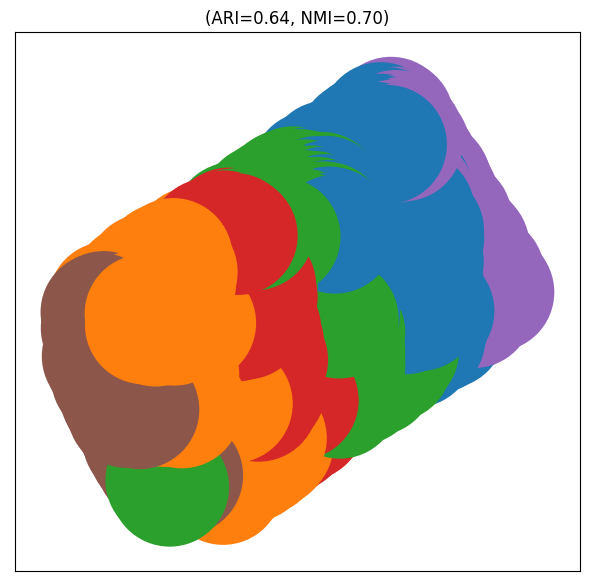

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sc.pl.spatial(adata, color='sf', ax=ax, show=False, spot_size=20, size=20, color_map='viridis',legend_loc=None)
# sc.pl.spatial(adata, color='mclust', ax=ax, show=False, spot_size=20)
ax.set_title('(ARI=%.2f, NMI=%.2f)' % (ARI, NMI))
ax.set_xlabel('')
ax.set_ylabel('')
output_dir = './sf_ARI_NMI'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, "sf_ba3_ARI.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [16]:
# output_dir1 = ('./feature')
# if not os.path.exists(output_dir1):
#     os.makedirs(output_dir1)
# output_path = os.path.join(output_dir1, f"ba2-SpaceFlow.h5ad")
# adata.write_h5ad(output_path)